In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mr_na\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mr_na\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1348
n_features: 1850
n_classes: 8
Extracting the top 150 eigenfaces from 1011 faces
done in 0.468s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.048s
Fitting the classifier to the training set
done in 66.693s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting people's names on the test set
done in 0.154s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.67      0.67        15
     Colin Powell       0.81      0.84      0.83        68
  Donald Rumsfeld       0.81      0.81      0.81        31
    George W Bush       0.88      0.87      0.88       126
Gerhard Schroeder       0.89      0.74      0.81        23
      Hugo Chavez       0.87      0.65      0.74        20
Junichiro Koizumi       0.85      0.92      0.88        12
       Tony Blair       0.80      0.93      0.86 

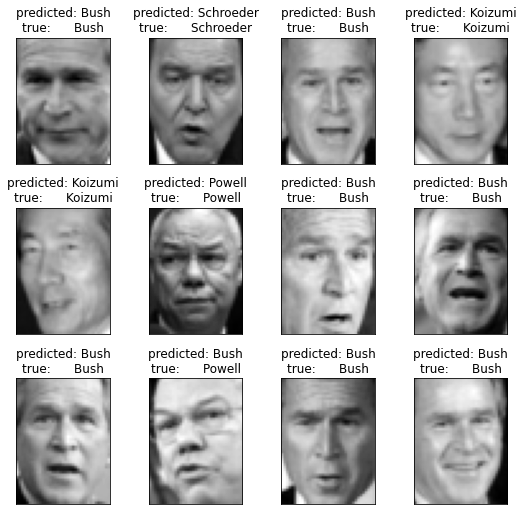

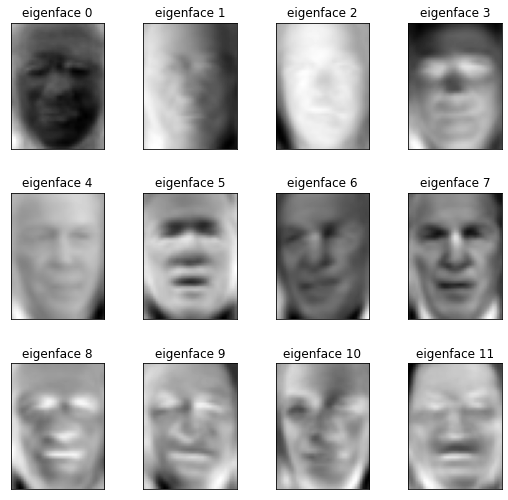

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=60, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 90% or more on a **holdout** dataset you kept for yourself.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline


In [3]:
train = pd.read_csv('data/labeledTrainData.tsv',delimiter = '\t')
test = pd.read_csv('data/testData.tsv',delimiter = '\t')

train.shape, test.shape

((25000, 3), (25000, 2))

In [4]:
from bs4 import BeautifulSoup

#Creating a function for cleaning of data
def clean_text(raw_text):
    # 1. remove HTML tags
    raw_text = BeautifulSoup(raw_text).get_text() 
    
    # 2. removing all non letters from text
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    
    # 4. Create variable which contain set of stopwords
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop word & returning   
    return [w for w in words if not w in stops]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
bow_transform = CountVectorizer(analyzer=clean_text).fit(train['review'])  #bow = bag of word

In [21]:
# bow1 = bow_transform.transform([review1])

In [8]:
#Creating bag of words for our review variable
review_bow = bow_transform.transform(train['review'])

In [9]:
#sparsity = (100.0 * review_bow.nnz / (review_bow.shape[0] * review_bow.shape[1]))

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(review_bow)
# tfidf1 = tfidf_transformer.transform(bow1)

In [23]:
review_tfidf = tfidf_transformer.transform(review_bow)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['review'], train['sentiment'], test_size=0.22, random_state=101)

len(X_train), len(X_test), len(X_train) + len(X_test)

(19500, 5500, 25000)

In [25]:
from sklearn.metrics import classification_report
#Predicting & Stats Function
def pred(predicted,compare):
    cm = pd.crosstab(compare,predicted)
    TN = cm.iloc[0,0]
    FN = cm.iloc[1,0]
    TP = cm.iloc[1,1]
    FP = cm.iloc[0,1]
    print("CONFUSION MATRIX ------->> ")
    print(cm)
    print()
    
    ##check accuracy of model
    print('Classification paradox :------->>')
    print('Accuracy :- ', round(((TP+TN)*100)/(TP+TN+FP+FN),2))
    print()
    print('False Negative Rate :- ',round((FN*100)/(FN+TP),2))
    print()
    print('False Postive Rate :- ',round((FP*100)/(FP+TN),2))
    print()
    print(classification_report(compare,predicted))

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=101)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
pred(predictions,y_train)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          9042   682
1           499  9277

Classification paradox :------->>
Accuracy :-  93.94

False Negative Rate :-  5.1

False Postive Rate :-  7.01

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9724
           1       0.93      0.95      0.94      9776

    accuracy                           0.94     19500
   macro avg       0.94      0.94      0.94     19500
weighted avg       0.94      0.94      0.94     19500



In [27]:
#Test Set Result
predictions = pipeline.predict(X_test)
pred(predictions,y_test)

CONFUSION MATRIX ------->> 
col_0         0     1
sentiment            
0          2424   352
1           267  2457

Classification paradox :------->>
Accuracy :-  88.75

False Negative Rate :-  9.8

False Postive Rate :-  12.68

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2776
           1       0.87      0.90      0.89      2724

    accuracy                           0.89      5500
   macro avg       0.89      0.89      0.89      5500
weighted avg       0.89      0.89      0.89      5500



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline_logit = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=101)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline_logit.fit(train['review'],train['sentiment'])
test['sentiment'] = pipeline_logit.predict(test['review'])

In [29]:
test.head(5)

,id,review,sentiment
0,12311_10,Naturally in a film who's main themes are of m...,1
1,8348_2,This movie is a disaster within a disaster fil...,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",1
3,7186_2,Afraid of the Dark left me with the impression...,1
4,12128_7,A very accurate depiction of small time mob li...,1


In [30]:

output = test[['id','sentiment']]
print(output)

             id  sentiment
0      12311_10          1
1        8348_2          0
2        5828_4          1
3        7186_2          1
4       12128_7          1
...         ...        ...
24995   2155_10          1
24996     59_10          1
24997    2531_1          0
24998    7772_8          1
24999  11465_10          1

[25000 rows x 2 columns]


In [31]:
output.to_csv( "output.csv", index=False, quoting=3 )